<a href="https://colab.research.google.com/github/geoskimoto/SNOTEL_AnomalyDetection/blob/fix_root/IsolationForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Helper Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotly import graph_objs as go
from functools import reduce
import requests
import xml.dom.minidom as minidom
import xml.etree.ElementTree as ET
import datetime

from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
# pip install eif

In [21]:
# import eif
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import statsmodels.tsa.filters as filters
from scipy.stats import zscore 

In [3]:
# Web Call to Access and Download Data of a Single Station from AWDB Web Service (SOAP API)

def SOAP_Call(stationtriplets, elementCD, begindate, enddate):

  # Create a dictionaries to store the data
  headers = {'Content-type': 'text/soap'}
  # current_dictionary = {}
  
  # Define Web Service URL
  URL = "https://wcc.sc.egov.usda.gov/awdbWebService/services?WSDL"

  # Define Parameters for SOAP Elements (getData:current and getCentralTendencyData:normals)
  SOAP_current = '''
  <?xml version="1.0" encoding="UTF-8"?>
  <SOAP-ENV:Envelope xmlns:SOAP-ENV="http://schemas.xmlsoap.org/soap/envelope/" xmlns:q0="http://www.wcc.nrcs.usda.gov/ns/awdbWebService" xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">
    <SOAP-ENV:Body>
      <q0:getData>
        <stationTriplets>STATIONTRIPLETS</stationTriplets>
        <elementCd>ELEMENTCD</elementCd>   
        <ordinal>1</ordinal>
        <duration>DAILY</duration>
        <getFlags>false</getFlags>
        <beginDate>BEGINDATE</beginDate>
        <endDate>ENDDATE</endDate>
        <alwaysReturnDailyFeb29>false</alwaysReturnDailyFeb29>   
      </q0:getData>
    </SOAP-ENV:Body>
  </SOAP-ENV:Envelope>

  '''.strip()
  #Read GetData documents - If <alwaysReturnDailyFeb29> is set to true, will set a null for every non leap year on the 29th,  
  #which breaks this request when selecting date ranges that include Feb 29.
  #Possible element codes: PREC, WTEQ (Water Equivalent/SWE)
  

  # Post SOAP Elements to AWDB Web Service and process results - getData
  SOAP_current = SOAP_current.replace("ELEMENTCD", elementCD)
  SOAP_current = SOAP_current.replace("STATIONTRIPLETS", stationtriplets)
  SOAP_current = SOAP_current.replace("BEGINDATE", begindate)
  SOAP_current = SOAP_current.replace("ENDDATE", enddate)

  response_current = requests.post(URL, data=SOAP_current, headers=headers)
  xmldoc = minidom.parseString(response_current.text)

  val_length = len(xmldoc.getElementsByTagName('values'))
  data = pd.DataFrame([xmldoc.getElementsByTagName('values')[i].firstChild.data for i in range(0,val_length)])

  date = datetime.datetime.strptime(begindate, "%m/%d/%Y").date()  #https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior; .date() after .strptime just tells it to make it a datetime object.  Def necessary.
  # print(date)
  Date = []                                                       
  for i in range(0, val_length): 
    date += datetime.timedelta(days=1)
    Date.append((date))

  data['Date'] = Date
  data.columns = [f'{elementCD}','Date']
  data.set_index('Date', inplace=True)
  
  data[f'{elementCD}'] = list(map(lambda x: float(x), data[f'{elementCD}']))
  
  return data

In [4]:
# Function to Download Multiple Stations at a time from AWDB Web Service

# stations = ['401:OR:SNTL', '471:ID:SNTL', '591:WA:SNTL']
def getData(stations, parameter_of_interest, begindate, enddate):

  data_singleDF = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), [SOAP_Call(stationtriplets=j,elementCD=parameter_of_interest,begindate=begindate,enddate=enddate) for j in stations])
  data_singleDF.columns = [f'{j}' for j in stations]

  return data_singleDF

## Isolation Forest Testing with Seasonal and Trend Differencing 

In [ ]:
# DATA = getData(['401:OR:SNTL'], 'TAVG', '10/01/2018', '01/30/2021')

In [ ]:
sd = seasonal_decompose(DATA,freq=365)

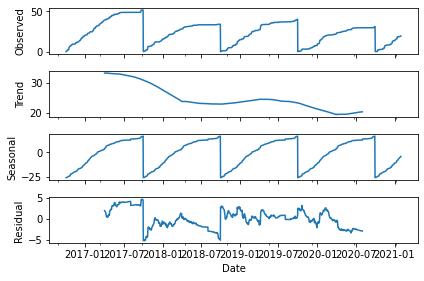

In [ ]:
sd.plot();

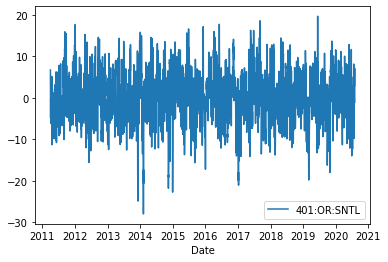

In [ ]:
sd.resid.plot()

In [ ]:
bk = filters.bk_filter  #(x=DATA, low=6, high=32, K=12)

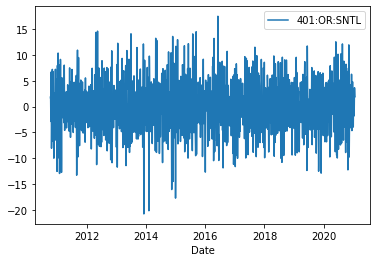

In [ ]:
bk.bkfilter(DATA, low=6, high=32, K=12).plot()

In [11]:
DATA = getData(['401:OR:SNTL'], 'TAVG', '10/01/2009', '01/30/2021')

In [40]:
sd = seasonal_decompose(DATA,freq=365)

X = sd.resid.dropna()
X_arr = np.array(X)
# data = DATA_array
scaler = StandardScaler()
X_arr_scaled = scaler.fit_transform(X)
X_arr_scaled = pd.DataFrame(X_arr_scaled)

# train isolation forest
model =  IsolationForest(n_estimators = 100, contamination = 0.05, bootstrap=False)
model.fit(X_arr_scaled)

predictions = model.predict(X_arr_scaled)
# predictions = pd.DataFrame(predictions)
# X = pd.DataFrame(X)
X['anomaly'] = predictions.tolist()

observed = sd.observed.dropna()
observed  = pd.merge(observed, X['anomaly'], left_index=True,right_index=True)
# observed['anomaly'] = predictions
# X_scaled['anomaly'] = predictions

# visualization
# fig, ax = plt.subplots(figsize=(20,12))

anomalies = X[X['anomaly'] == -1] #anomaly
anomalies2 = observed[observed['anomaly'] == -1]

# ax.plot(observed.index, observed.iloc[:,0], color='blue', label = 'Normal')
# # ax.plot(X.index, X.iloc[:,0], color='blue', label = 'Normal')
# ax.scatter(pd.to_datetime(anomalies2.index), anomalies2.iloc[:,0], color='red', label = 'Anomaly')
# plt.legend()
# plt.show();


fig = go.Figure()

fig.add_trace(go.Scatter(
  x=observed.index,
  y=observed.iloc[:,0],
  mode='lines',
  name= 'Normal',
  hovertext = observed.iloc[:,0],   
))

fig.add_trace(go.Scatter(
  x=anomalies2.index,
  y=anomalies2.iloc[:,0],
  mode='markers',
  name= 'Anomaly',
  hovertext = anomalies2.index,   
))

fig.update_xaxes(title_text = 'Date')
# fig.update_yaxes(title_text = parameter_of_interest)

fig.update_layout(
  height=800,
  width=1100,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
observed[observed['anomaly']==-1]

,401:OR:SNTL,anomaly
Date,,
2011-04-22,30.74,-1
2011-06-02,39.92,-1
2011-06-09,41.54,-1
2011-09-01,45.32,-1
2011-09-08,69.44,-1
...,...,...
2020-06-29,43.88,-1
2020-06-30,49.82,-1
2020-07-01,48.38,-1


### Isolation Forest wo Seasonal or Trend Differencing

In [ ]:
DATA = getData(['401:OR:SNTL'], 'PREC', '10/01/2014', '01/30/2021')

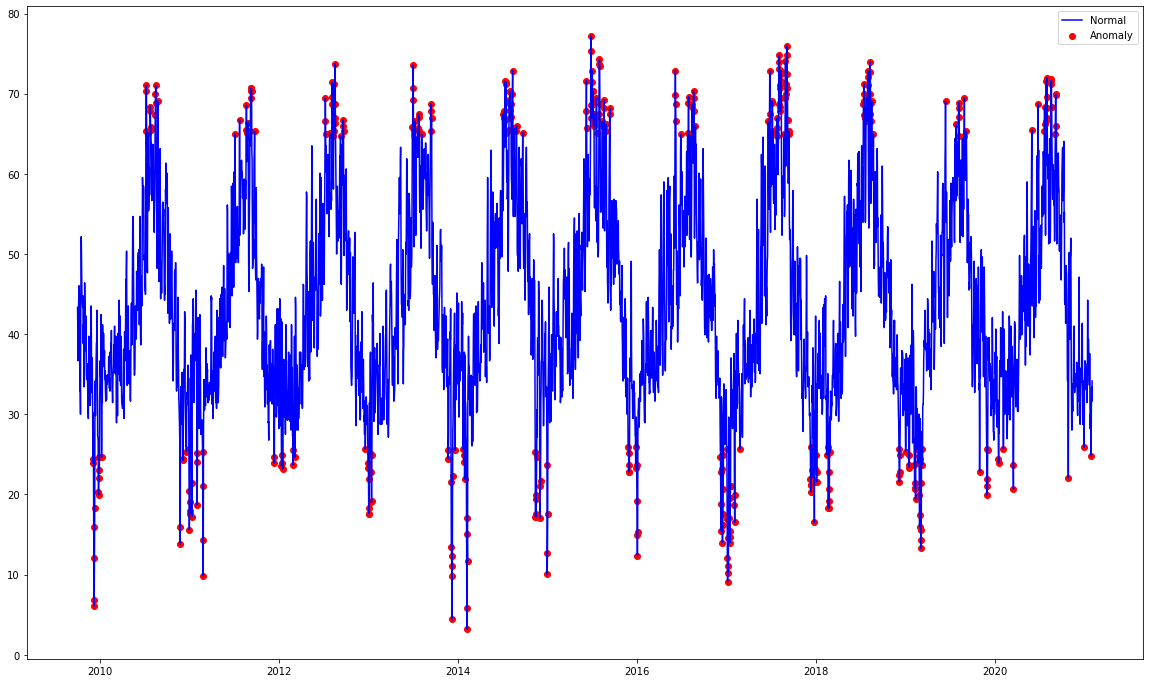

In [18]:
# outliers_fraction = 0.05
data = np.array(DATA.dropna())
# data = DATA_array
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest
model =  IsolationForest(n_estimators = 100, contamination = 0.1, bootstrap=True)
model.fit(data) 
DATA['anomaly2'] = model.predict(data)

# visualization
fig, ax = plt.subplots(figsize=(20,12))

a = DATA.loc[DATA['anomaly2'] == -1] #anomaly

ax.plot(DATA.index, DATA['401:OR:SNTL'], color='blue', label = 'Normal')
ax.scatter(a.index, a['401:OR:SNTL'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

## Z Score with Seasonal and Trend Differencing

In [28]:
del X

In [65]:
del zs, X

In [57]:
df = getData(['401:OR:SNTL'], 'TAVG', '10/01/2017', '01/30/2021')

In [80]:
def zScore_plot(df, max_StDev=2.5, plot_type = 'interactive', seasonal_differencing = True):
  global zs,  X

  if seasonal_differencing == True:
    #Remove season and trend from input data.
    sd = seasonal_decompose(df,freq=365)
    X = sd.resid.dropna()
    zs = zscore(X.iloc[:,0], ddof=1, nan_policy='omit')
    X['zscore'] = zs

    observed = sd.observed.dropna()
    observed  = pd.merge(observed, X['zscore'], left_index=True,right_index=True)
    anomalies = observed[(observed['zscore'] < -max_StDev) | (observed['zscore'] > max_StDev)] #anomaly

  elif seasonal_differencing == False:
    # X_arr = np.array(X)
    X = df.dropna()
    zs = zscore(X.iloc[:,0], ddof=2, nan_policy='omit')
    X['zscore'] = zs

    observed = X
    anomalies = X[(X['zscore'] < -max_StDev) | (X['zscore'] > max_StDev)]

  




    # X = np.array(df.dropna())
    # scaler = StandardScaler()
    # np_scaled = scaler.fit_transform(X)
    # X = pd.DataFrame(np_scaled)
    # # train isolation forest
    # model =  IsolationForest(n_estimators = 100, contamination = 0.1, bootstrap=True)
    # model.fit(X)

    # observed = df 
    # observed['anomaly2'] = model.predict(X)
    # anomalies = observed.loc[observed['anomaly2'] == -1]






  # matplotlib visualization
  if plot_type == 'static':

    fig, ax = plt.subplots(figsize=(20,12))
    observed = sd.observed.dropna()
    ax.plot(observed.index, observed.iloc[:,0], color='blue', label = 'Normal')
    # ax.plot(X.index, X.iloc[:,0], color='blue', label = 'Normal')
    ax.scatter(pd.to_datetime(anomalies.index), anomalies.iloc[:,0], color='red', label = 'Anomaly')
    plt.legend()
    plt.show();

  # plotly visualization
  elif plot_type == 'interactive':

    fig = go.Figure()

    fig.add_trace(go.Scatter(
      x=observed.index,
      y=observed.iloc[:,0],
      mode='lines',
      name= 'Normal',
      hovertext = observed.iloc[:,0],   
    ))

    fig.add_trace(go.Scatter(
      x=anomalies.index,
      y=anomalies.iloc[:,0],
      mode='markers',
      name= 'Anomaly',
      hovertext = anomalies.index,   
    ))

    fig.update_xaxes(title_text = 'Date')
    # fig.update_yaxes(title_text = parameter_of_interest)

    fig.update_layout(
      height=800,
      width=1100,
    )
    fig.show()
  else:
    'Choose either static or interactive for plot_type'



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



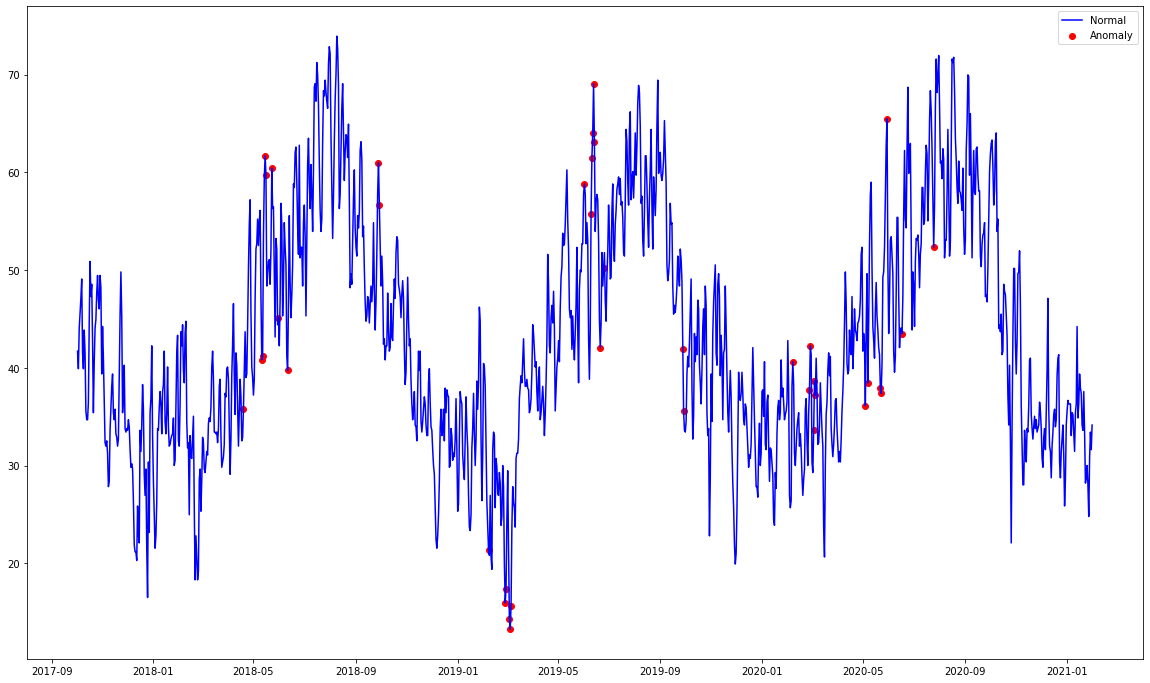

In [84]:
zScore_plot(df,max_StDev=2.0,plot_type='static',seasonal_differencing=True)

In [46]:
zs.shape

(3776, 2)

## Experimenting with PYOD package

In [ ]:
pip install pyod

In [ ]:
import pyod

In [ ]:
SOS_model = pyod.models.sos.SOS()

In [ ]:
sd = seasonal_decompose(DATA,freq=365)

X = sd.resid.dropna()
X_arr = np.array(resid)

SOS_model.fit(X_arr)
X['anomaly'] = SOS_model.predict(DATA)


/usr/local/lib/python3.7/dist-packages/pyod/models/sos.py:202: RuntimeWarning:

overflow encountered in multiply



KeyboardInterrupt: ignored